<a href="https://colab.research.google.com/github/jpraveenkanna/Style_generator-Video_and_Image/blob/master/Style_generator%5BImages%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Packages
import cv2
import tarfile
import tempfile
from six.moves import urllib
import numpy as np
import os
from google.colab.patches import cv2_imshow
import json
import requests

%tensorflow_version 1.x
import tensorflow as tf

_TARBALL_NAME = 'deeplab_model.tar.gz'
model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

#Downloading the model
download_path = os.path.join(model_dir, _TARBALL_NAME)
urllib.request.urlretrieve('http://download.tensorflow.org/models/deeplabv3_pascal_train_aug_2018_01_04.tar.gz', download_path)

#Loading model
class DeepLabModel(object):
  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run_inferance(self, image):

    
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(image)]})
    seg_map = batch_seg_map[0]
    return image, seg_map

MODEL = DeepLabModel(download_path)


TensorFlow 1.x selected.


In [0]:
def get_result(input_image,style_image):
  input_image_copy_for_requests = input_image
  cv2_imshow(input_image_copy_for_requests)
  #Preprocessing image
  original_height = input_image.shape[0]
  original_width =input_image.shape[1]
  original_resolution = (original_width,original_height)
  #resizing for model inputs
  INPUT_SIZE= 513
  height = input_image.shape[0]
  width =input_image.shape[1]
  resize_ratio = 1.0 * INPUT_SIZE / max(width, height)
  target_size = (int(resize_ratio * width), int(resize_ratio * height))
  input_image = cv2.resize(input_image,target_size,fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
  style_image = cv2.normalize(src=style_image, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
  style_image = cv2.resize(style_image,target_size,fx=0,fy=0, interpolation = cv2.INTER_CUBIC)

  height = input_image.shape[0]
  width =input_image.shape[1]

  

  #Extract persons in the image
  _, seg_map = MODEL.run_inferance(input_image)
  person_seg = seg_map
  np.place(person_seg, person_seg != 15, 0)
  mask = np.dstack((person_seg, person_seg,person_seg))
  img_background = (mask)*input_image 
  img_background = cv2.normalize(src=img_background, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
  person_extracted = cv2.resize(img_background,(width,height),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
  #cv2_imshow(person_extracted)

  #get Mask
  _, seg_map = MODEL.run_inferance(input_image)
  getMask = seg_map
  np.place(getMask, getMask != 15, 1) 
  np.place(getMask, getMask == 15, 0) 

  img_background = cv2.normalize(src=getMask, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
  mask = cv2.resize(img_background,(width,height),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
  #cv2_imshow(mask)

  # apply style 
  raw_mask = np.dstack((getMask, getMask,getMask))
  extract_background = (style_image)* raw_mask
  extract_background1 = cv2.normalize(src=extract_background, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
  background = cv2.resize(extract_background1,(width,height),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
  #cv2_imshow(background)

  extract_person = (style_image)* (1-raw_mask)
  extract_person1 = cv2.normalize(src=extract_person, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
  peson1 = cv2.resize(extract_person1,(width,height),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
  #cv2_imshow(peson1)


  #style background
  stylized_pic = (extract_background)+person_extracted #background stylized
  stylized_pic_normalized = cv2.normalize(src=stylized_pic, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
  stylized_pic_view = cv2.resize(stylized_pic_normalized,original_resolution,fx=0,fy=0, interpolation = cv2.INTER_CUBIC)

  cv2_imshow(stylized_pic_view)

  #Style person
  stylized_pic_person = (input_image * (raw_mask))+(extract_person) #person stylized
  stylized_pic_person_normalized = cv2.normalize(src=stylized_pic_person, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
  stylized_pic_person_view = cv2.resize(stylized_pic_person_normalized,original_resolution,fx=0,fy=0, interpolation = cv2.INTER_CUBIC)

  cv2_imshow(stylized_pic_person_view)

  #Person styled - light
  stylized_img_light = (extract_person* (1-raw_mask))+input_image #person stylized

  stylized_img_light_normalized = cv2.normalize(src=stylized_img_light, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
  stylized_img_light_normalized_view = cv2.resize(stylized_img_light_normalized,original_resolution,fx=0,fy=0, interpolation = cv2.INTER_CUBIC)

  cv2_imshow(stylized_img_light_normalized_view)
  final_images_packed = json.dumps({"input_image": input_image_copy_for_requests.tolist(),
                           "background_styled":stylized_pic_view.tolist(),
                           "person_styled": stylized_pic_person_view.tolist(),
                           "stylized_img_light": stylized_img_light_normalized_view.tolist()
                           })
  return final_images_packed
  
def process_style(source_style,input_image,url):
  data = json.dumps({"style_image": source_style.tolist(),
                   "source_image": input_image.tolist()})

  headers = {'content-type': 'application/json'}
  response = requests.post(url, json = data, headers = headers)
  loading_data = response.json()
  style_image = np.asarray(loading_data["style_image"])
  return style_image


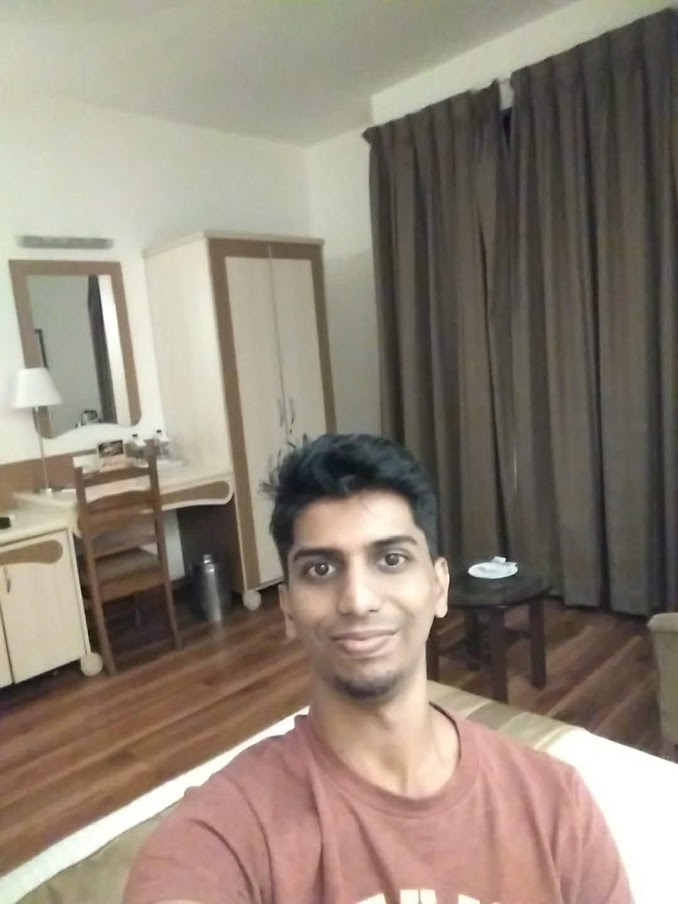

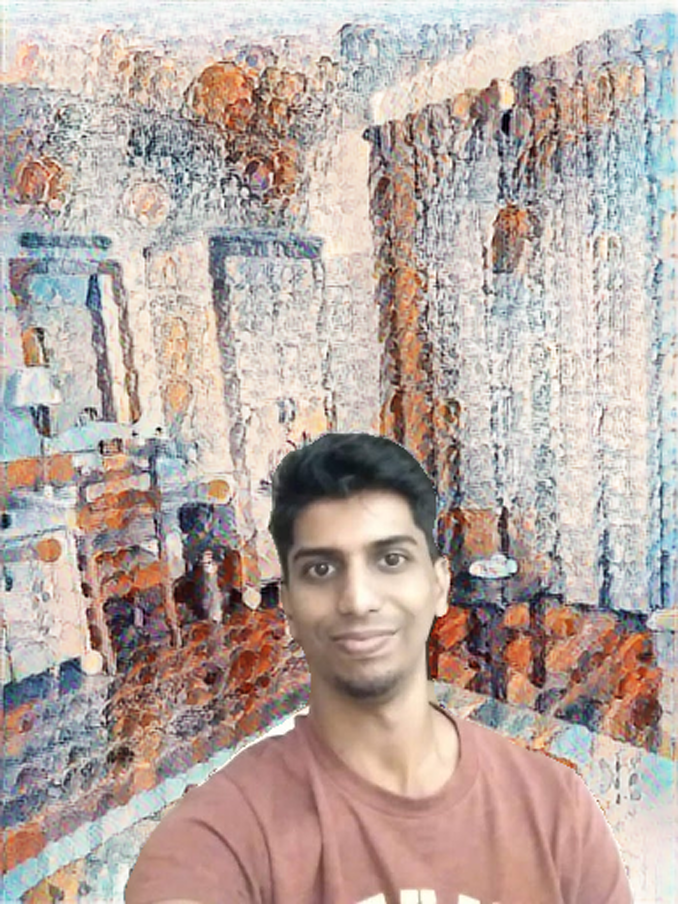

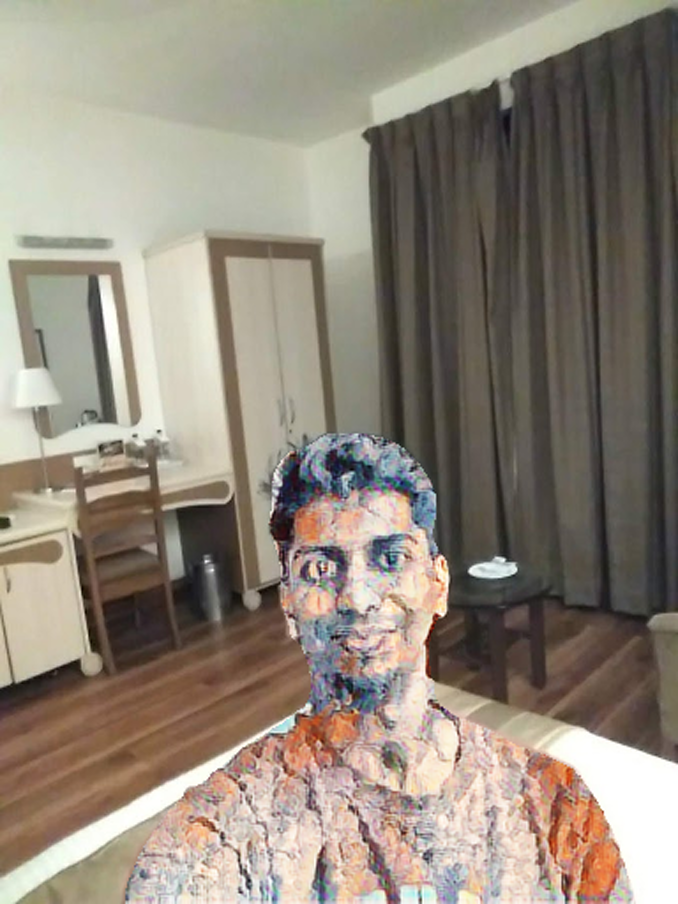

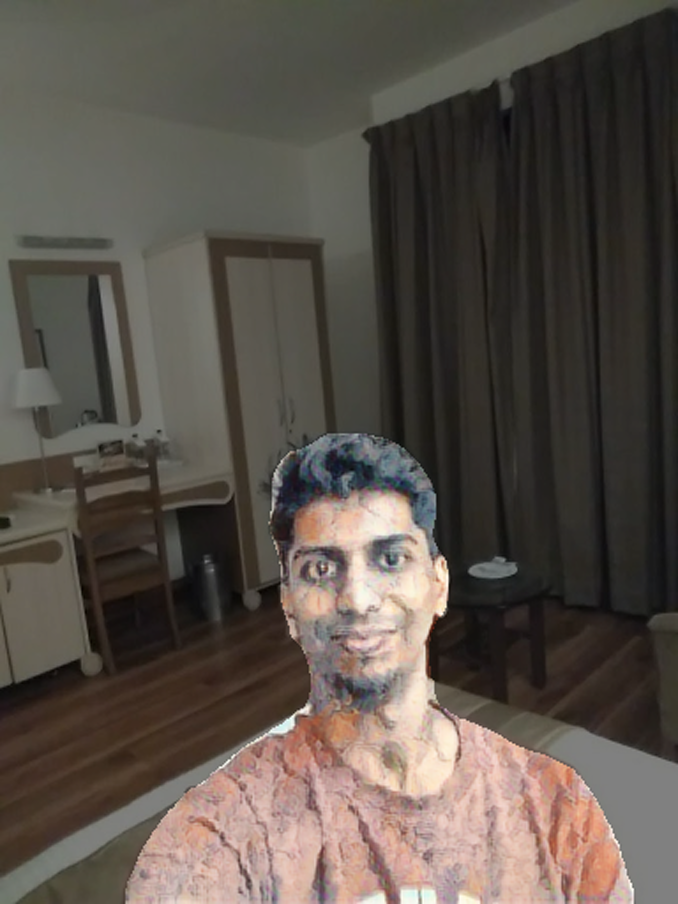

In [10]:
source_style = cv2.imread("/content/style1.jpeg") #Reference style to be applied
input_image = cv2.imread("/content/3.jpg") #Original Image

"""
run Style_Transfer_Model.ipynb in seperate session

obtain API URL to make POST request.

"""
url = "http://5114ad06.ngrok.io/style" 

style_image = process_style(source_style,input_image,url) #model1

#cv2_imshow(style_image)
response = get_result(input_image,style_image) #model 2

In [11]:
#Loading image from JSON
results = json.loads(response)
results.keys()

dict_keys(['input_image', 'background_styled', 'person_styled', 'stylized_img_light'])

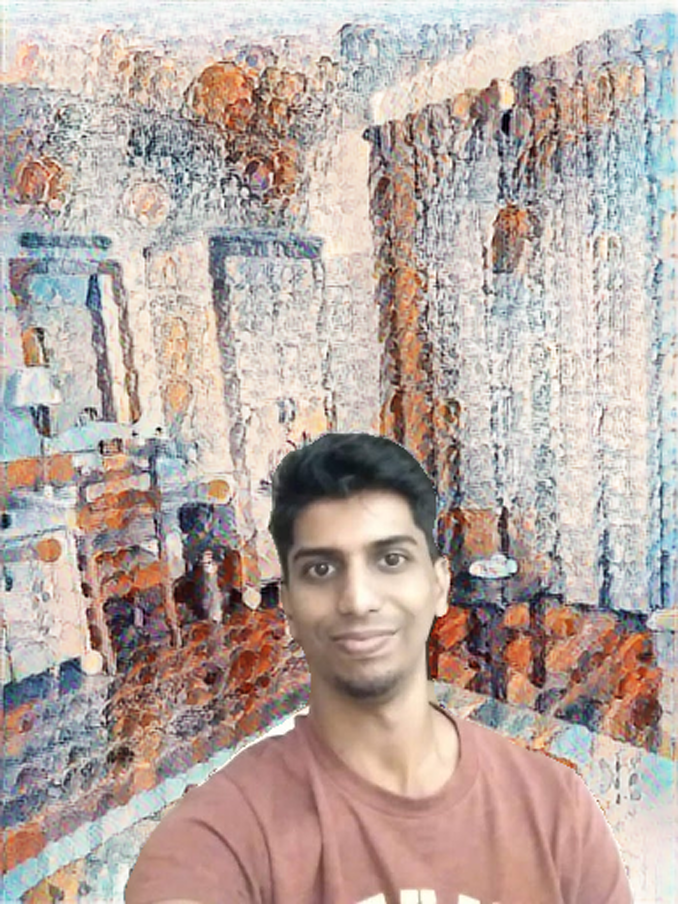

In [12]:
#Selecting the style image to view 
cv2_imshow(np.asarray(results["background_styled"]))

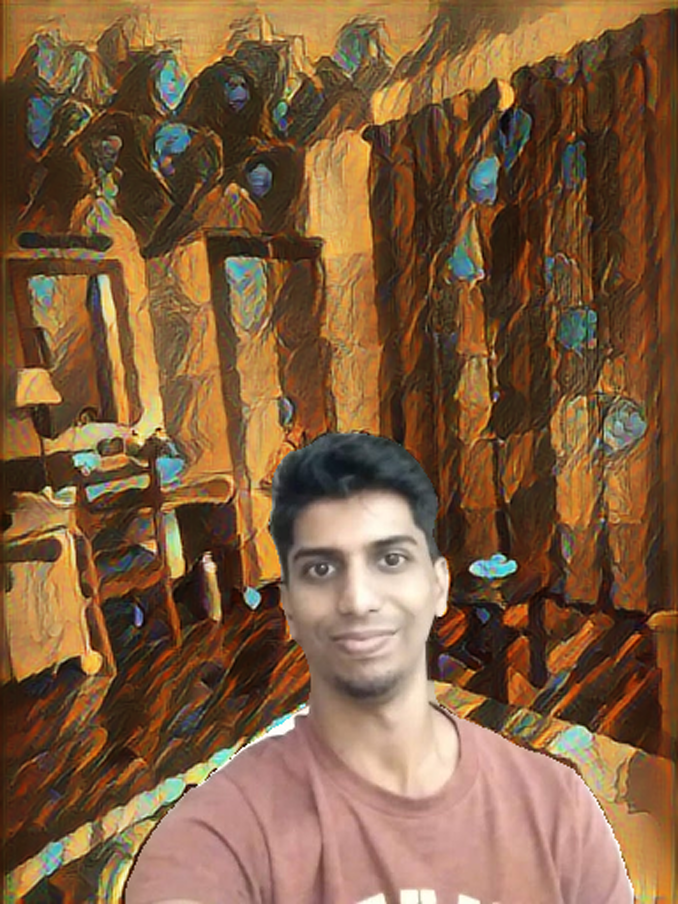

In [9]:
#Other Sample results

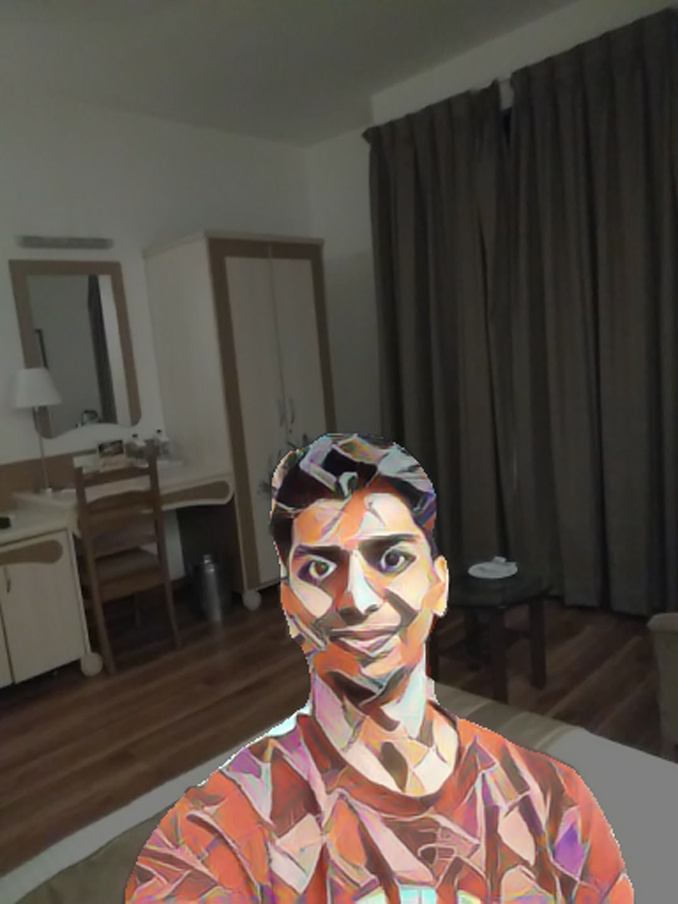

In [5]:
#Other Sample results